In [1]:
import pandas as pd
from sqlalchemy import create_engine
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import warnings

from homeloans.tables import Application,PreviousApplication
from homeloans.tables import get_session
from homeloans.tables import initialise_database

%matplotlib inline
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

Descriptive Statistics
======================

This workbook looks at the [Kaggle Home Credit Default Risk](https://www.kaggle.com/c/home-credit-default-risk) data. The data model is provided in below ER-diagram:

![er_diag](https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png)

In [2]:
db_fn = "H:\\kaggle\\home_loans\\db\\home_loans.db"
initialise_database(db_fn, drop=False, echo=False)
session = get_session()

In [3]:
qry = session.query(Application).filter(Application.target.isnot(None))

In [4]:
df_appl = pd.read_sql(qry.statement, qry.session.bind)

In [5]:
def get_relative_counts(df, hue, col):
    return (df.groupby(hue)[col]
            .value_counts(normalize=True)
            .rename('fraction')
            .reset_index()
            .sort_values(col))

def categorical_plot(df, hue, col, show_rel_labels=True, rotate_x=None, rotate_bar_labels=None, figsize=None, sort_by_fraction=False):
    cnts = get_relative_counts(df, hue, col)
    if not figsize:
        fig, ax = plt.subplots()
    else:
        fig, ax = plt.subplots(1, figsize=figsize)
    if sort_by_fraction:
        cnts.sort_values(by="fraction", ascending=False, inplace=True)
    sns.barplot(x=col, y="fraction", hue=hue, data=cnts, ax=ax)
    ax.set_xlabel("%s (missing=%.3f%%)" % (col, df[col].isnull().sum()*100/len(df)))
    #handles, labels = ax.get_legend_handles_labels() 
    #total = df.groupby(hue)[col].count()
    if show_rel_labels:
        for i, p in enumerate(ax.patches):
            #label_pos = labels[i % len(labels)]
            height = p.get_height()
            rotation = rotate_bar_labels or 0
            ax.text(p.get_x()+p.get_width()/2.,
                    height,
                    '%.2f' % height,
                    ha="center",
                    va="bottom",
                    rotation=rotation)
    if rotate_x:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=rotate_x)
    return ax

def numerical_plot(df, hue, col, winsorize=None, violin_kwargs=None, box_kwargs=None):
    fig, (ax_top, ax_bottom) = plt.subplots(2, figsize=(10, 10), gridspec_kw={'height_ratios':[3, 1]})
    
    if winsorize:
        df = pd.DataFrame(df[[col, hue]])
        quantiles = df[col].quantile(winsorize)
        q_lwr = quantiles.loc[winsorize[0]]
        q_upr = quantiles.loc[winsorize[1]]
        #df = df[(df[col] >= q_lwr) & (df[col] <= q_upr)]
        df.loc[df[col] < q_lwr, col] = q_lwr
        df.loc[df[col] > q_upr, col] = q_upr
        
    df["all"] = ""
    
    box_kwargs = box_kwargs or {}
    sns.boxplot(y=col, x="all", hue=hue, data=df, ax=ax_top, **box_kwargs)
    
    violin_kwargs = violin_kwargs or {}
    sns.violinplot(y="all", x=col, hue=hue, data=df, split=True, ax=ax_bottom, cut=0, **violin_kwargs)
    return (ax_top, ax_bottom)

def correlation_heatmap(df, col1, col2, col1min=None, col1max=None, col2min=None, col2max=None, col1bins=11, col2bins=11, figsize=None, ax=None, heatmap_kwargs=None):
    heatmap_kwargs = heatmap_kwargs or {}
    if not ax:
        if figsize:
            fig, ax = plt.subplots(1, figsize=figsize)
        else:
            fig, ax = plt.subplots(1)
        
    if col1min is None:
        col1min = df[col1].min()
    if col2min is None:
        col2min = df[col2].min()
    if col1max is None:
        col1max = df[col1].max()
    if col2max is None:
        col2max = df[col2].max()
        
    ser1 = pd.cut(df[col1], bins=np.linspace(col1min, col1max, col1bins))
    ser2 = pd.cut(df[col2], bins=np.linspace(col2min, col2max, col2bins))
    df12 = pd.concat([ser1, ser2], axis=1)
    df12 = df12[(~df12[col1].isnull()) & (~df12[col2].isnull())]
    df12["cnt"] = 1
    df12["cnt"] = df12["cnt"]/df12["cnt"].sum()
    df12_piv = df12.groupby([col1, col2]).cnt.sum().reset_index().pivot(col1, col2, "cnt")
    df12_piv = df12_piv.fillna(0)
    df12_piv.sortlevel(ascending=False, inplace=True)
    return sns.heatmap(df12_piv, ax=ax, **heatmap_kwargs)
    
def correlation_matrix_plot(df, cols, colmins=None, colmaxs=None, colbins=None, figsize=None, vmin=None, vmax=None):
    colmins = colmins or {}
    colmaxs = colmaxs or {}
    colbins = colbins or {}

    if vmin is None:
        vmin = 0
    if vmax is None:
        vmax = 1
    ncols = len(cols)
    if figsize:
        fig, axs = plt.subplots(nrows=ncols, ncols=ncols, figsize=figsize)
    else:
        fig, axs = plt.subplots(nrows=ncols, ncols=ncols)    
    
    cbar_ax = fig.add_axes([.91, .3, .03, .4])
    
    for i in range(len(cols)):
        c1 = cols[i]
        for j in range(len(cols)):
            c2 = cols[j]
            if i == j:
                sns.distplot(df[~df[cols[i]].isnull()][cols[i]], ax=axs[i, j], bins=np.linspace(colmins[c2], colmaxs[c2], 100))
            else:
                cbarax = correlation_heatmap(df, col1=c1, col2=c2, 
                                    col1min=colmins.get(c1), col2min=colmins.get(c2),
                                    col1max=colmaxs.get(c1), col2max=colmaxs.get(c2),
                                    col1bins=colbins.get(c1, 11), col2bins=colbins.get(c2, 11),
                                    ax=axs[i, j],
                                    heatmap_kwargs={"cbar": i == 0 and j == 1,
                                                    "vmin": vmin,
                                                    "vmax": vmax,
                                                    "cbar_ax": cbar_ax if (i == 0 and j == 1) else None})
            axs[i, j].set_xlabel("")
            axs[i, j].set_ylabel("")
    return fig, axs    

#### Contract Type

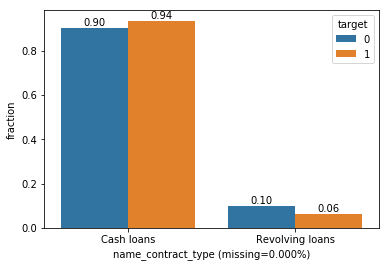

In [6]:
categorical_plot(df=df_appl, hue="target", col="name_contract_type");

#### Gender

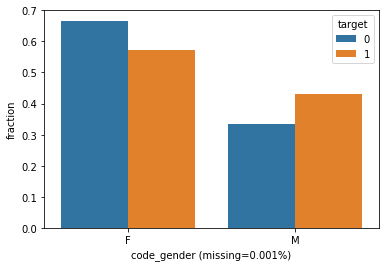

In [7]:
categorical_plot(df=df_appl, hue="target", col="code_gender", show_rel_labels=False);

#### Own Car

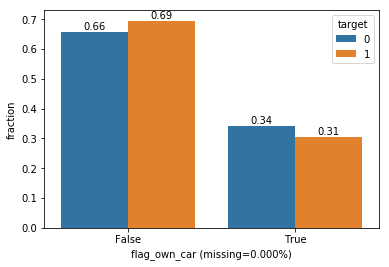

In [8]:
categorical_plot(df=df_appl, hue="target", col="flag_own_car");

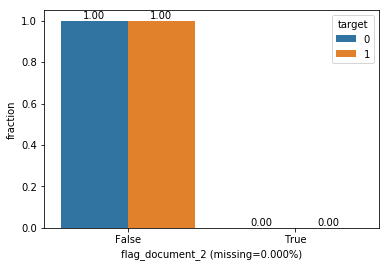

In [9]:
categorical_plot(df=df_appl, hue="target", col="flag_document_2");

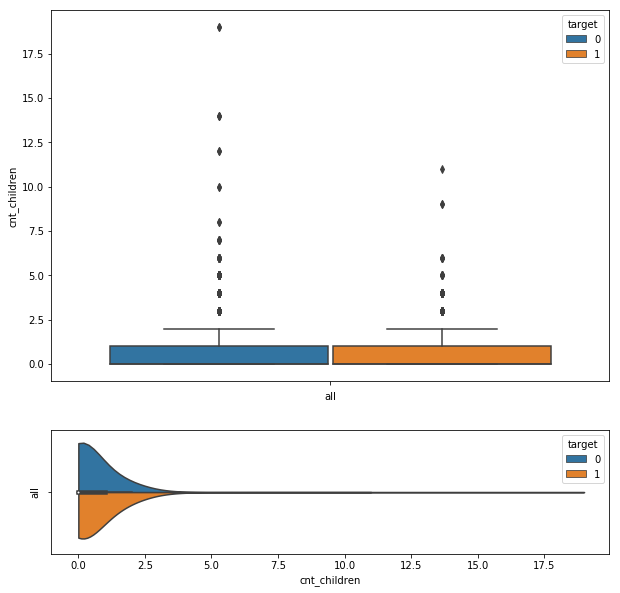

In [10]:
numerical_plot(df_appl, "target", "cnt_children", violin_kwargs={"bw": 1});

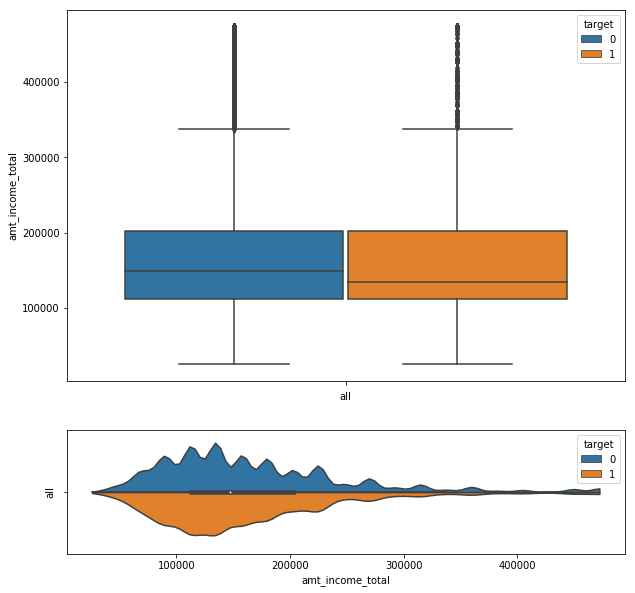

In [11]:
numerical_plot(df_appl, "target", "amt_income_total", winsorize=(0, 0.99));

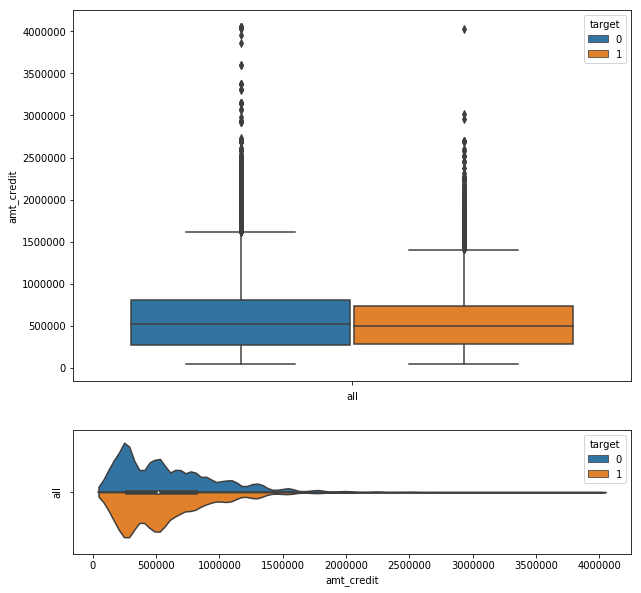

In [12]:
numerical_plot(df_appl, "target", "amt_credit");

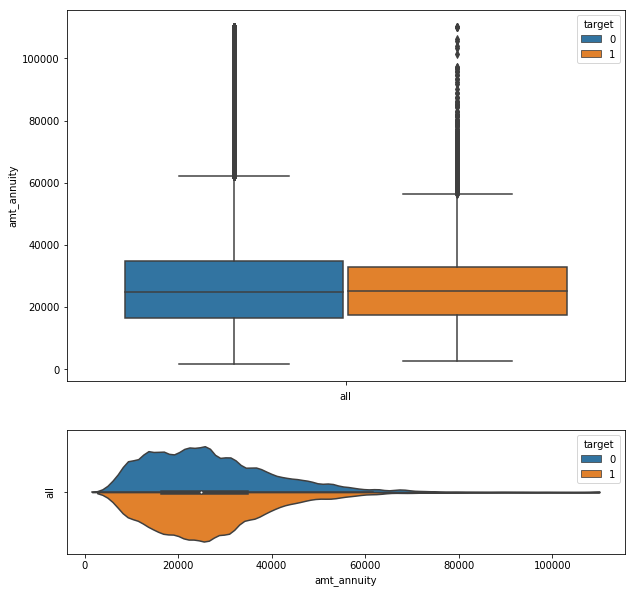

In [13]:
numerical_plot(df_appl, "target", "amt_annuity", winsorize=(0, 0.999));

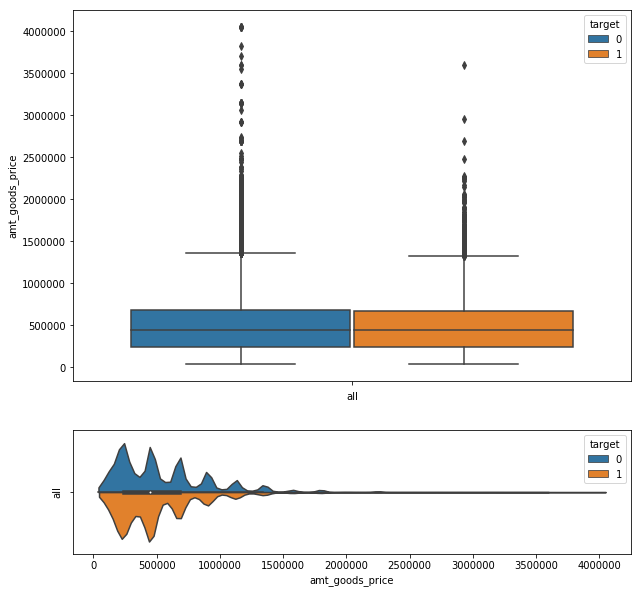

In [14]:
numerical_plot(df_appl, "target", "amt_goods_price");

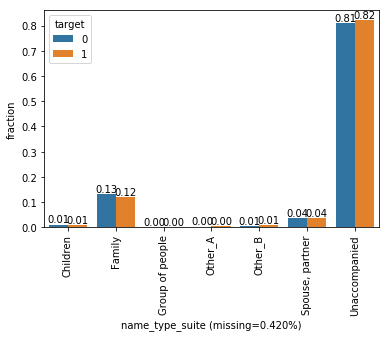

In [15]:
categorical_plot(df_appl, "target", "name_type_suite", rotate_x=90);

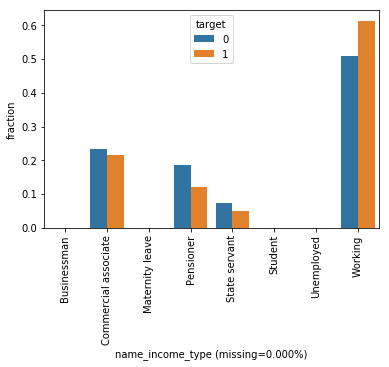

In [16]:
categorical_plot(df_appl, "target", "name_income_type", rotate_x=90, show_rel_labels=False);

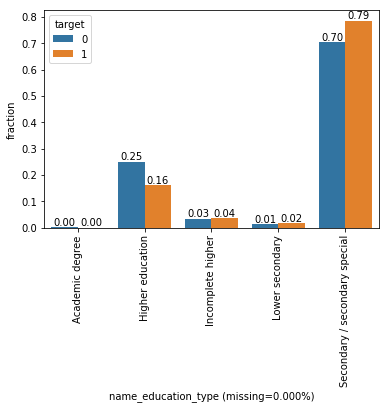

In [17]:
categorical_plot(df_appl, "target", "name_education_type", rotate_x=90);

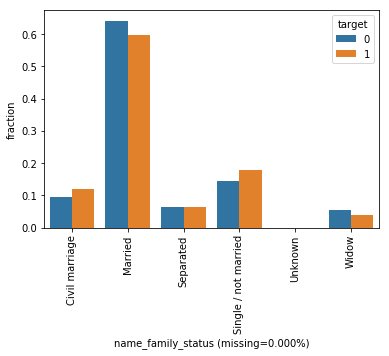

In [18]:
categorical_plot(df_appl, "target", "name_family_status", rotate_x=90, show_rel_labels=False);

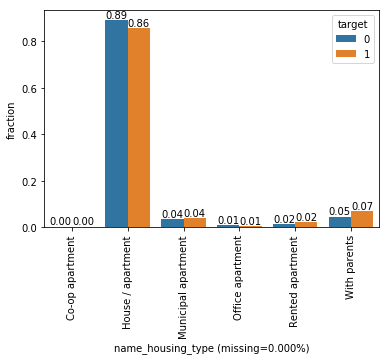

In [19]:
categorical_plot(df_appl, "target", "name_housing_type", rotate_x=90);

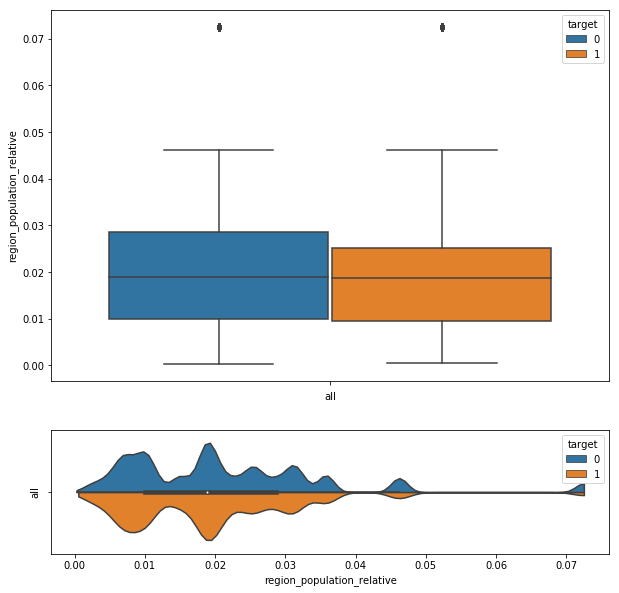

In [20]:
numerical_plot(df_appl, "target", "region_population_relative");

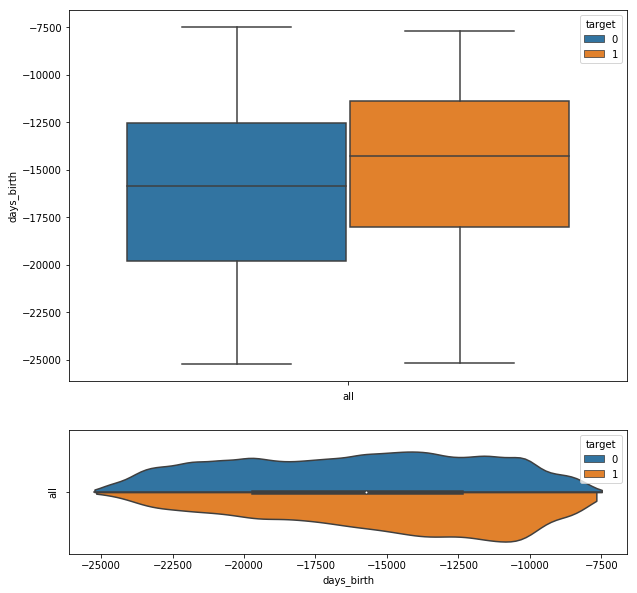

In [21]:
numerical_plot(df_appl, "target", "days_birth");

#### Days employed

`days_employed` is intended to show the number of days before an application an applicant started his current employment. Therefore, observed values should be exclusively non-positive - nevertheless, we see a number of very high positive values which we replace with "missing".

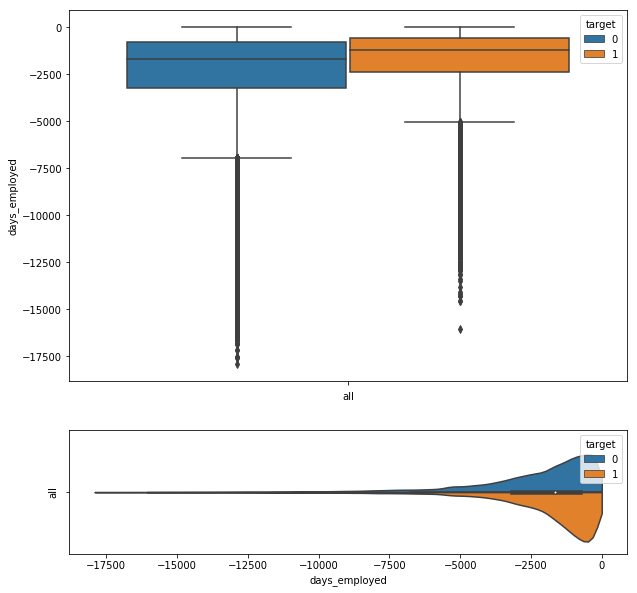

In [22]:
df_appl.loc[df_appl.days_employed > 0, 'days_employed'] = np.NaN
numerical_plot(df_appl, "target", "days_employed");

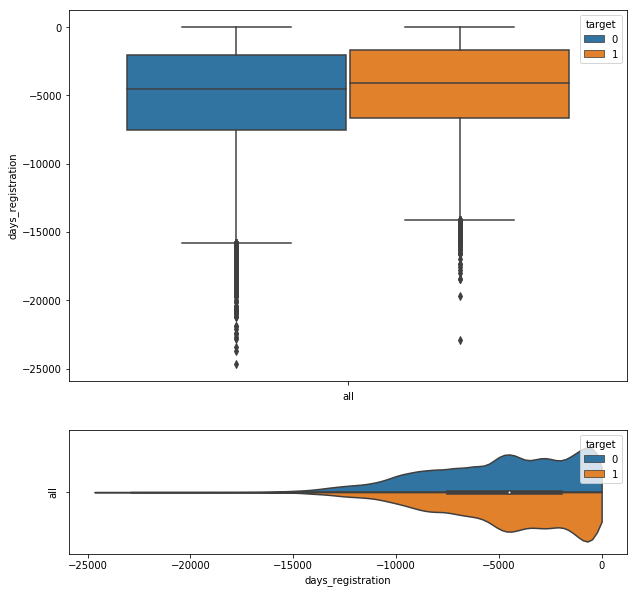

In [23]:
numerical_plot(df_appl, "target", "days_registration");

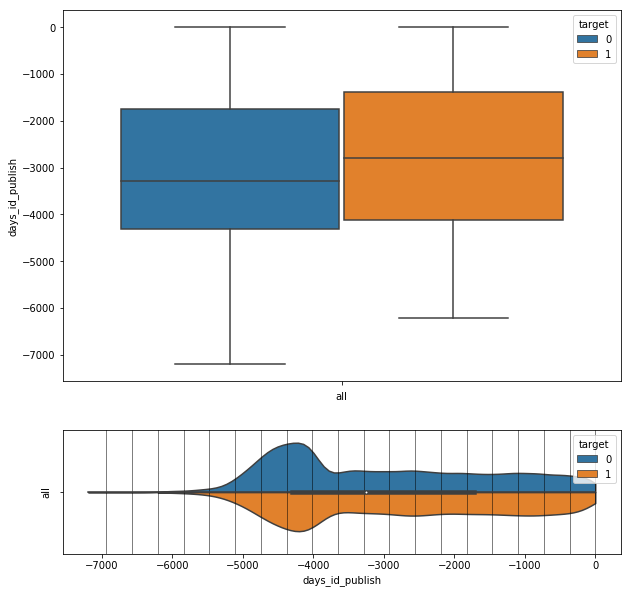

In [24]:
ax = numerical_plot(df_appl, "target", "days_id_publish")
ax[1].vlines(x=[-365*i for i in range(20)], ymin=-1, ymax=1, lw=0.5);

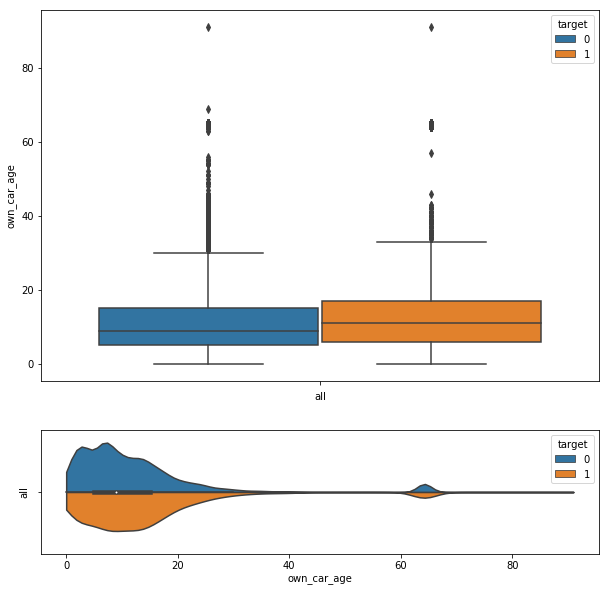

In [25]:
numerical_plot(df_appl, "target", "own_car_age");

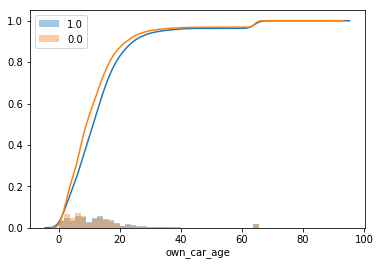

In [26]:
ax = sns.distplot(df_appl[(df_appl.target == 1.0) & (~df_appl.own_car_age.isnull())].own_car_age,
            kde_kws=dict(cumulative=True), label="1.0")
sns.distplot(df_appl[(df_appl.target == 0.0) & (~df_appl.own_car_age.isnull())].own_car_age,
            kde_kws=dict(cumulative=True), ax=ax, label="0.0")
ax.legend();

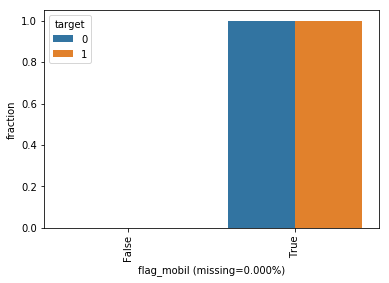

In [27]:
categorical_plot(df_appl, "target", "flag_mobil", rotate_x=90, show_rel_labels=False);

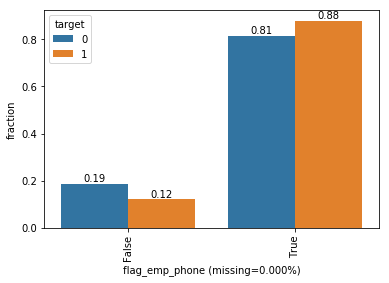

In [28]:
categorical_plot(df_appl, "target", "flag_emp_phone", rotate_x=90, show_rel_labels=True);

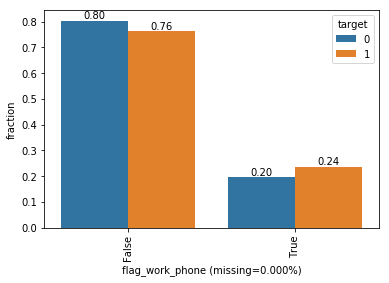

In [29]:
categorical_plot(df_appl, "target", "flag_work_phone", rotate_x=90, show_rel_labels=True);

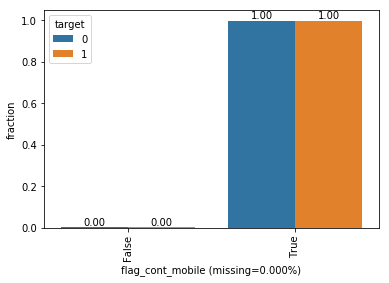

In [30]:
categorical_plot(df_appl, "target", "flag_cont_mobile", rotate_x=90, show_rel_labels=True);

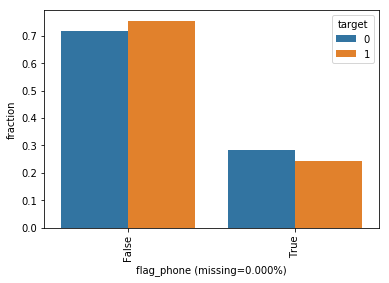

In [31]:
categorical_plot(df_appl, "target", "flag_phone", rotate_x=90, show_rel_labels=False);

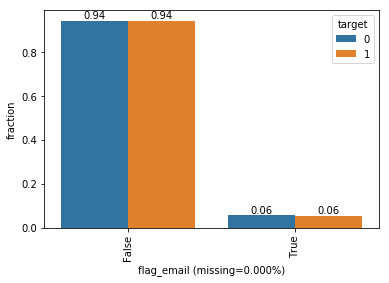

In [32]:
categorical_plot(df_appl, "target", "flag_email", rotate_x=90, show_rel_labels=True);

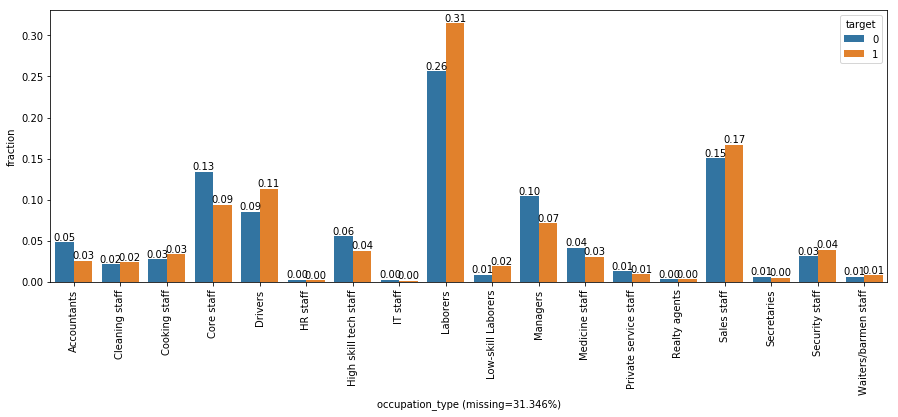

In [33]:
categorical_plot(df_appl, "target", "occupation_type", rotate_x=90, show_rel_labels=True, figsize=(15, 5));

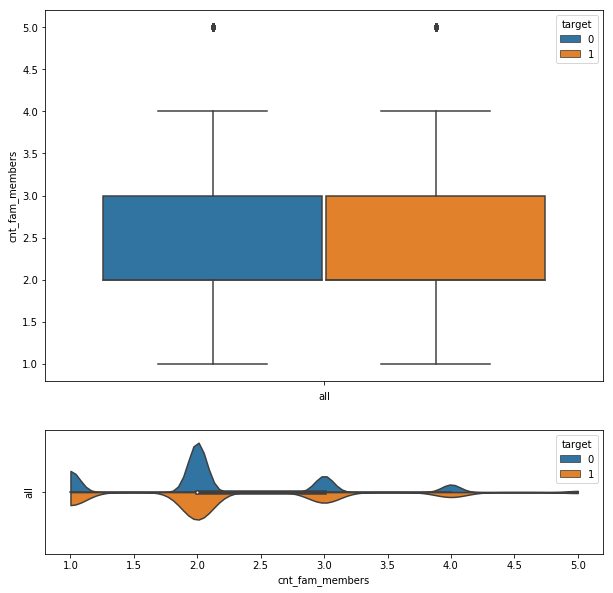

In [34]:
numerical_plot(df_appl, "target", "cnt_fam_members", winsorize=(0, 0.99));

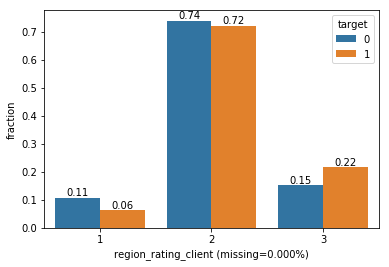

In [35]:
categorical_plot(df_appl, "target", "region_rating_client");

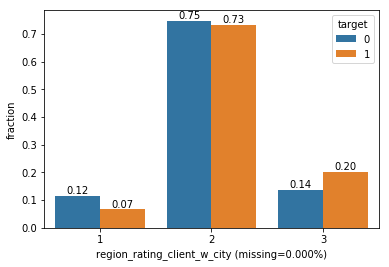

In [36]:
categorical_plot(df_appl, "target", "region_rating_client_w_city");

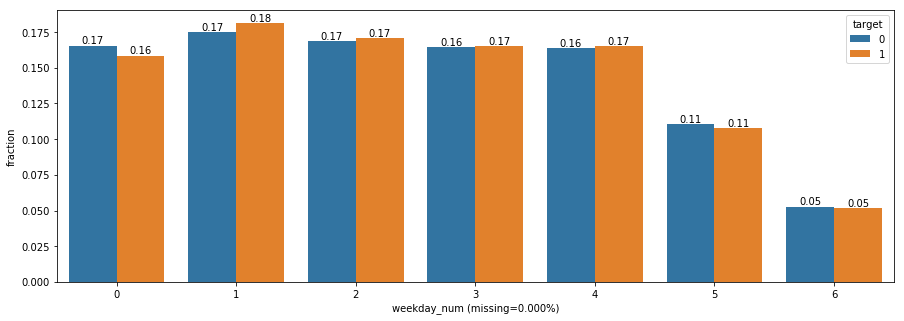

In [37]:
day_map = {"MONDAY": 0,
           "TUESDAY": 1,
           "WEDNESDAY": 2,
           "THURSDAY": 3,
           "FRIDAY": 4,
           "SATURDAY": 5,
           "SUNDAY": 6}
df_appl["weekday_num"] = df_appl.weekday_appr_process_start.apply(lambda x: day_map.get(x))
categorical_plot(df_appl, "target", "weekday_num", figsize=(15, 5));

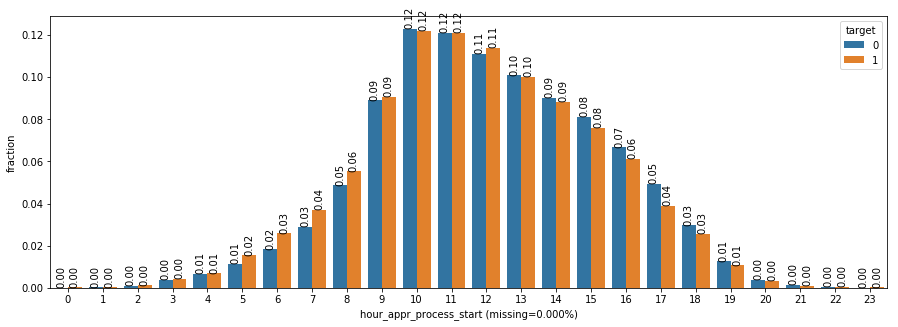

In [38]:
categorical_plot(df_appl, "target", "hour_appr_process_start", rotate_bar_labels=90, figsize=(15,5));

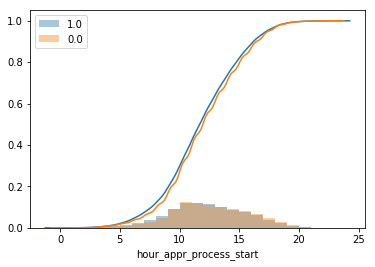

In [39]:
ax = sns.distplot(df_appl[(df_appl.target == 1.0) & (~df_appl.hour_appr_process_start.isnull())].hour_appr_process_start,
            kde_kws=dict(cumulative=True), label="1.0", bins=np.arange(24))
sns.distplot(df_appl[(df_appl.target == 0.0) & (~df_appl.hour_appr_process_start.isnull())].hour_appr_process_start,
            kde_kws=dict(cumulative=True), ax=ax, label="0.0", bins=np.arange(24))
ax.legend();

### A look at the registration and living region

The following plots show whether the region of the applicant's registration differs from their working or living regions.

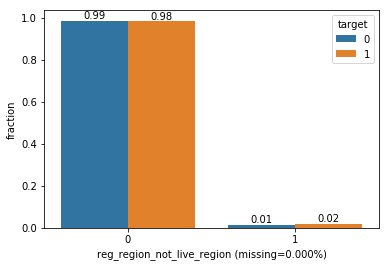

In [40]:
categorical_plot(df_appl, "target", "reg_region_not_live_region");

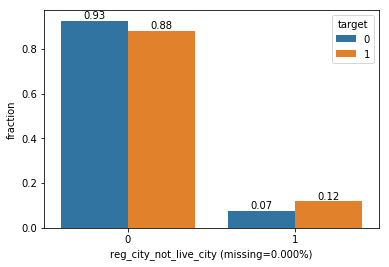

In [41]:
categorical_plot(df_appl, "target", "reg_city_not_live_city");

The region and city information is likely to be not independent - in most cases, whenever the region is the same, then also the city should be the same. Let's verify this:

In [42]:
df_appl[df_appl.reg_region_not_live_region == 0].reg_city_not_live_city.value_counts()

0    282599
1     20255
Name: reg_city_not_live_city, dtype: int64

Our hyothesis is falsified as indeed there are examples where a city seems to be broken into multiple regions. Nevertheless, let's still take a look at the condition number of a potential design matrix holding only the two predictors to identify potential collinearity:

In [43]:
df_appl["ones"] = 1
np.linalg.cond(df_appl[["ones", "reg_region_not_live_region", "reg_city_not_live_city"]])

8.859767183980797

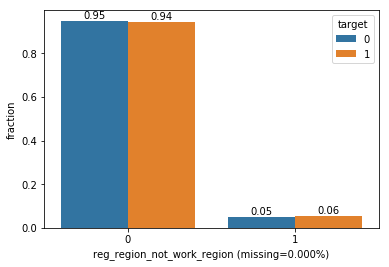

In [44]:
categorical_plot(df_appl, "target", "reg_region_not_work_region");

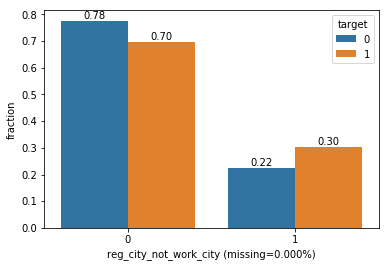

In [45]:
categorical_plot(df_appl, "target", "reg_city_not_work_city");

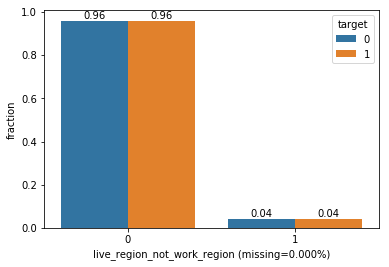

In [46]:
categorical_plot(df_appl, "target", "live_region_not_work_region");

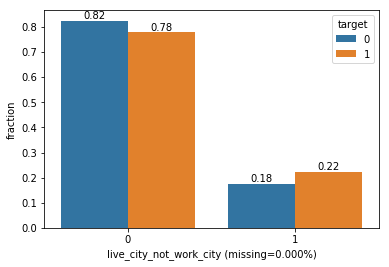

In [47]:
categorical_plot(df_appl, "target", "live_city_not_work_city");

### Which are the areas applicants work in?

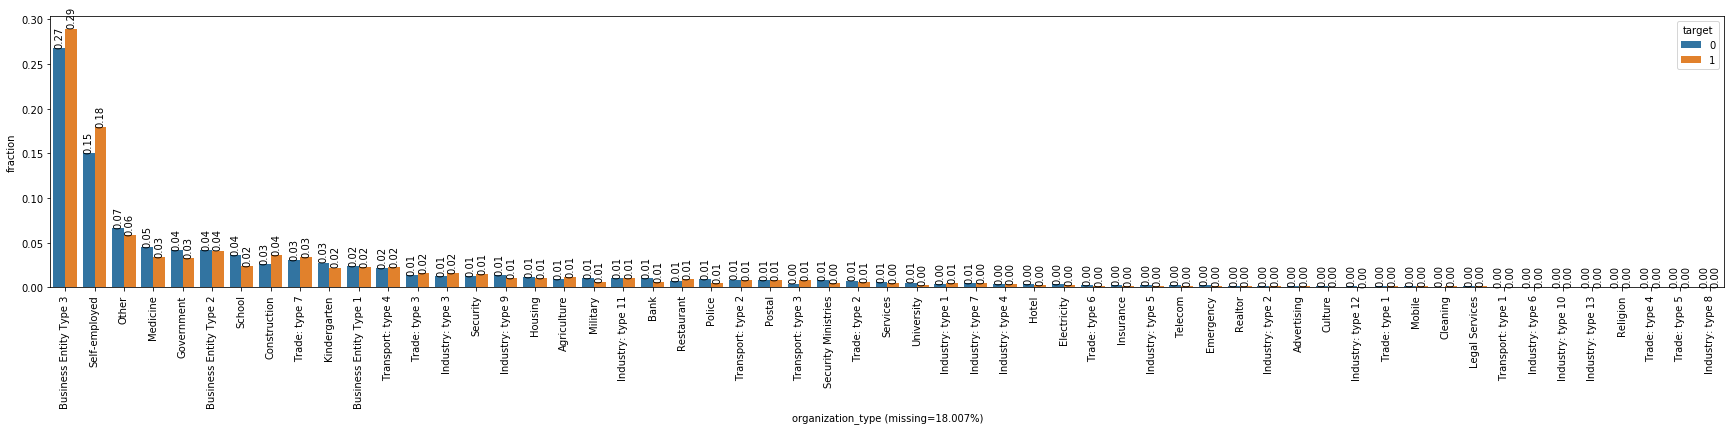

In [48]:
df_appl.loc[df_appl.organization_type == "XNA", "organization_type"] = None
categorical_plot(df_appl, "target", "organization_type", figsize=(30, 5), rotate_x=90, rotate_bar_labels=90, sort_by_fraction=True);

Let's collapse business, industry, trade and transport entries

In [49]:
def collapse_org_type(x):
    if not x:
        return x
    
    if "Business Entity Type" in x:
        return "Business"
    elif "Industry: type" in x:
        return "Industry"
    elif "Trade: type" in x:
        return "Trade"
    elif "Transport: type" in x:
        return "Transport"
    else:
        return x

df_appl["organization_type_collapsed"] = df_appl.organization_type.apply(collapse_org_type)

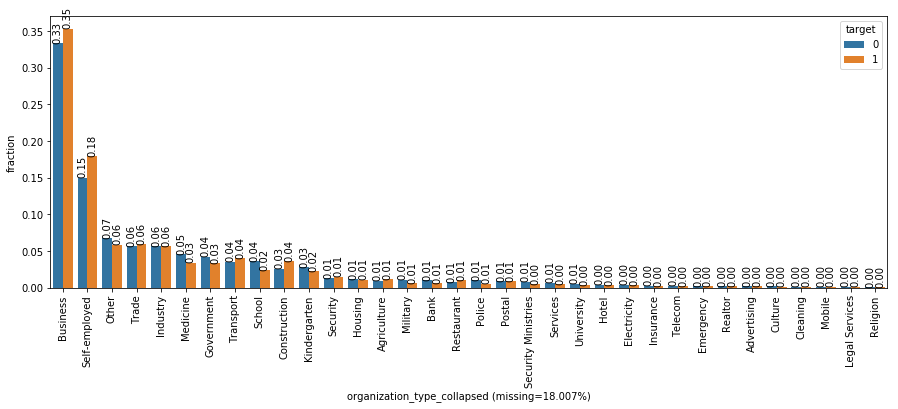

In [50]:
categorical_plot(df_appl, "target", "organization_type_collapsed", figsize=(15, 5), rotate_x=90, rotate_bar_labels=90, sort_by_fraction=True);

### Applicant Score from external sources

The data includes normalised scores from three external sources (EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3).

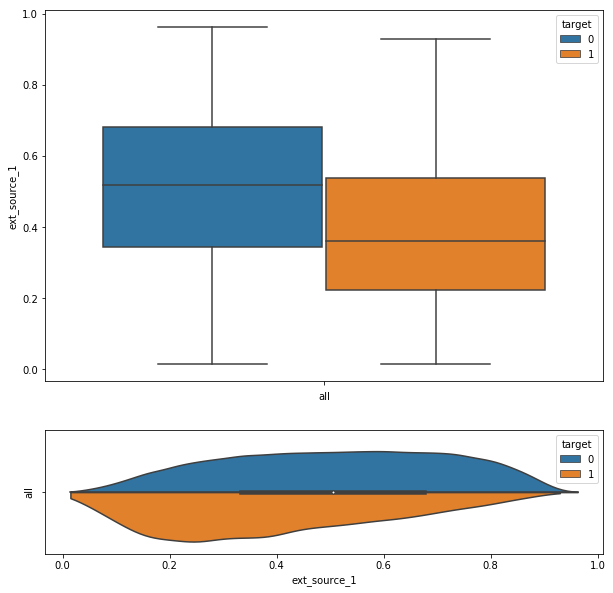

In [51]:
numerical_plot(df_appl, "target", "ext_source_1");

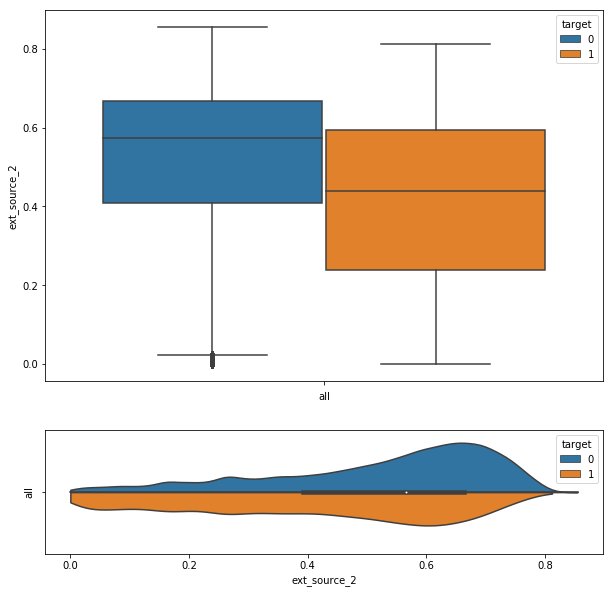

In [52]:
numerical_plot(df_appl, "target", "ext_source_2");

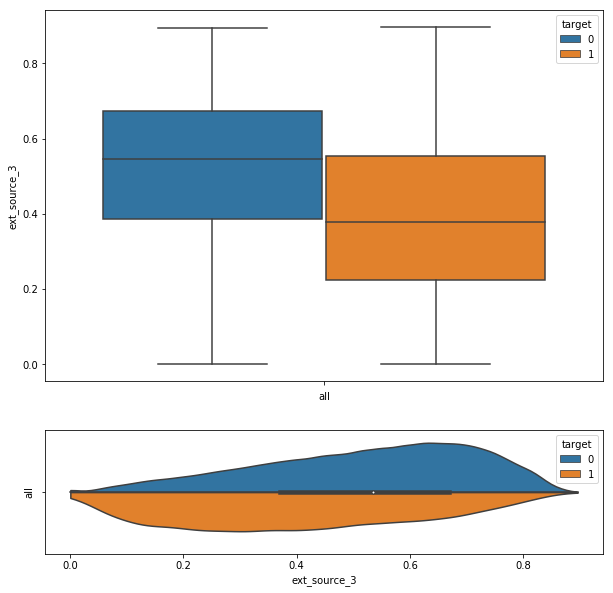

In [53]:
numerical_plot(df_appl, "target", "ext_source_3");

For all of them, a lower score seems to indicate lower credit-worthiness (at least by judging by realised defaults). Let's look at the correlation matrix:

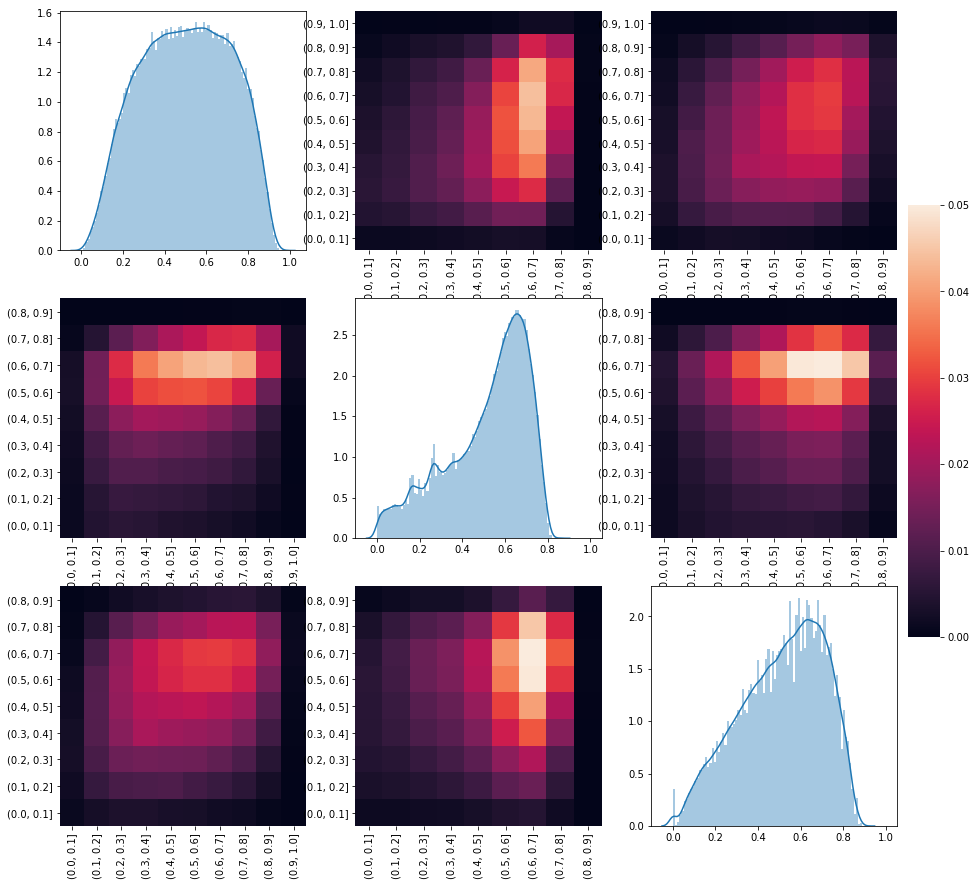

In [54]:
fig, axs = correlation_matrix_plot(df_appl, cols=["ext_source_1", "ext_source_2", "ext_source_3"], 
                        colmins={"ext_source_1": 0,
                                 "ext_source_2": 0,
                                 "ext_source_3": 0}, 
                        colmaxs={"ext_source_1": 1,
                                 "ext_source_2": 1,
                                 "ext_source_3": 1},
                        colbins={"ext_source_1": 11,
                                 "ext_source_2": 11,
                                 "ext_source_3": 11},
                        vmin=0, vmax=0.05, figsize=(15, 15));

### Information on buildings where the client lives

The file contains various average statistics on the building the applicant lives in.  Below, we are just showing the respective averages for the number of apartments.

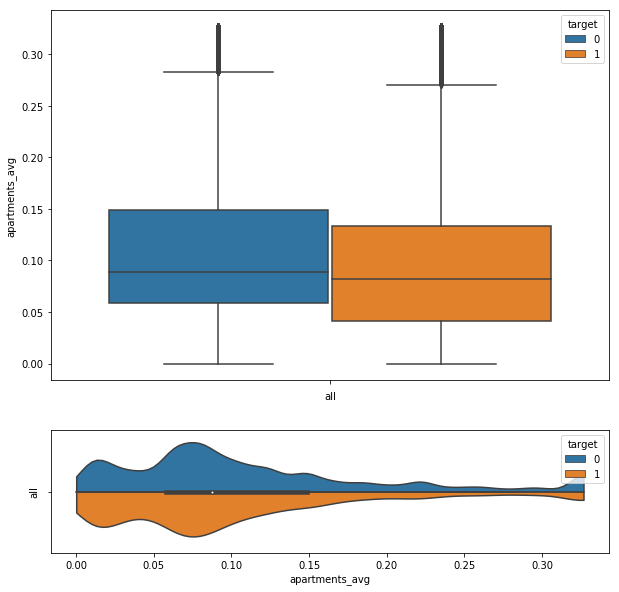

In [55]:
numerical_plot(df_appl, "target", "apartments_avg", winsorize=(0, 0.95));

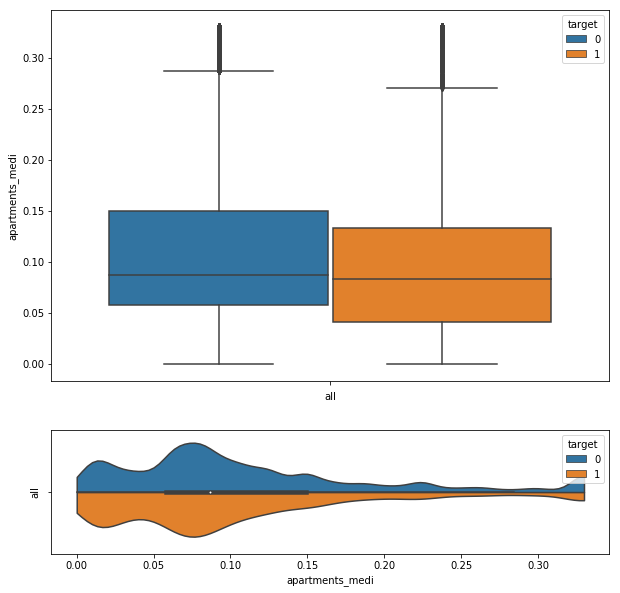

In [56]:
numerical_plot(df_appl, "target", "apartments_medi", winsorize=(0, 0.95));

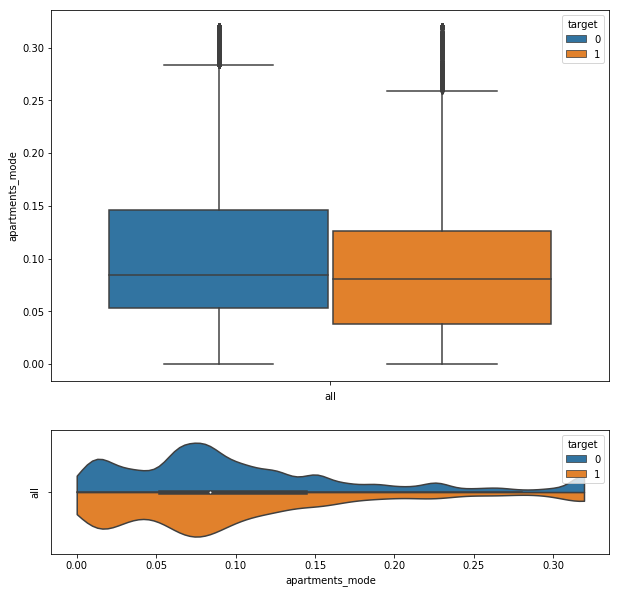

In [57]:
numerical_plot(df_appl, "target", "apartments_mode", winsorize=(0, 0.95));

In [58]:
np.linalg.cond(df_appl[(~df_appl.apartments_avg.isnull()) & (~df_appl.apartments_medi.isnull())][["apartments_avg", "apartments_medi"]])

29.687675583830103

### Defaults in social surroundings

DEF_-variables are always lower or equal to OBS_-values.

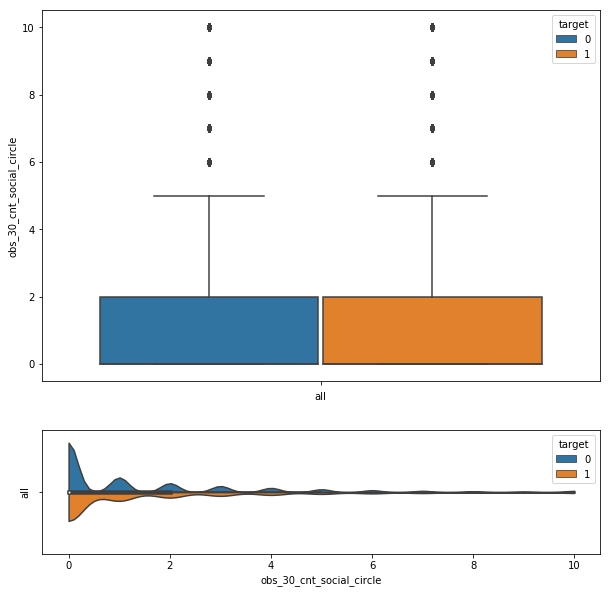

In [59]:
numerical_plot(df_appl, "target", "obs_30_cnt_social_circle", winsorize=(0, 0.99));

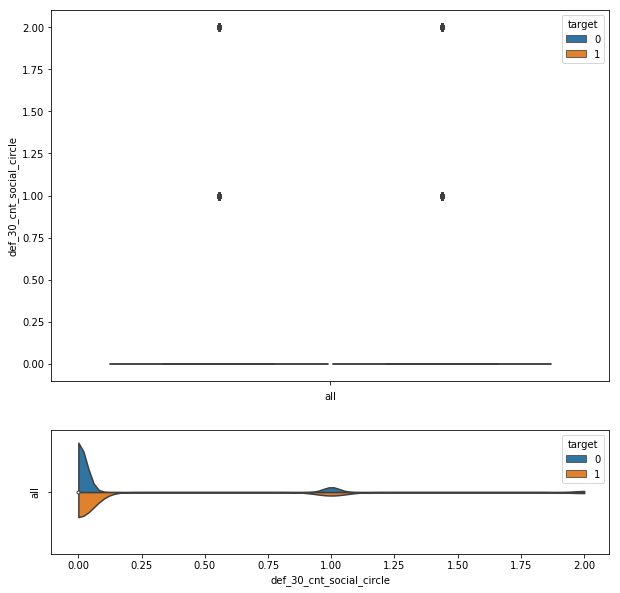

In [60]:
numerical_plot(df_appl, "target", "def_30_cnt_social_circle", winsorize=(0, 0.99));

### Phone changes

How many days before application did the client change phone?

missing observations: 3.2519161916159095e-06


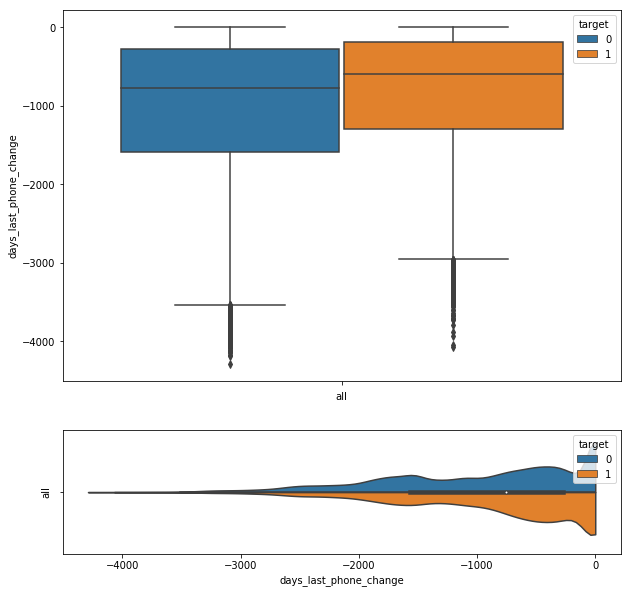

In [61]:
numerical_plot(df_appl, "target", "days_last_phone_change");
print("missing observations:", (df_appl.days_last_phone_change.isnull().sum())/len(df_appl))

### Which documents did the applicant provide?

Document flags are available for all observations. Document 3, which is provided by the largest share of applicants, seems to be provided by defaulting parties more often.

In [62]:
df_doc = df_appl[["target"]+["flag_document_" + str(i) for i in range(2, 22)]]
total_pos = (df_doc.target == 1).sum()
total_neg = (df_doc.target == 0).sum()
df_doc_pos = df_doc[df_doc.target == 1]
df_doc_neg = df_doc[df_doc.target == 0]

In [63]:
df_doc_pos_sums = df_doc_pos.sum()/total_pos
df_doc_neg_sums = df_doc_neg.sum()/total_neg

In [64]:
doc_counts = pd.concat((df_doc_neg_sums, df_doc_pos_sums), axis=1)
doc_counts.drop("target", axis=0, inplace=True)

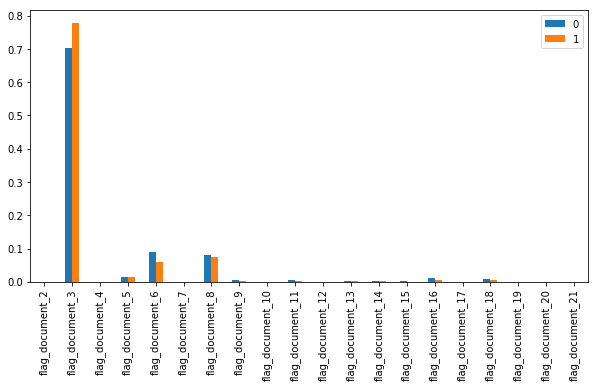

In [65]:
fig, ax = plt.subplots(1, figsize=(10, 5))
doc_counts.plot(kind="bar", ax=ax);

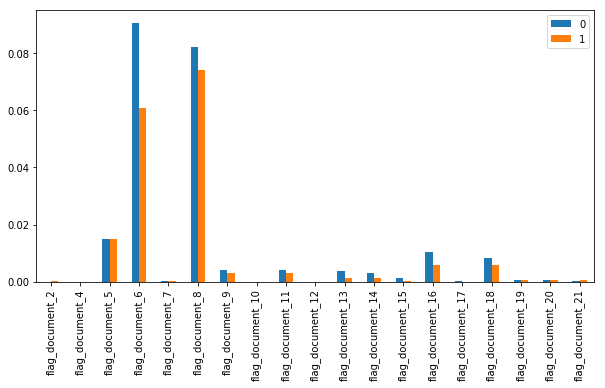

In [66]:
doc_counts_no_3 = doc_counts.drop("flag_document_3", axis=0)
fig, ax = plt.subplots(1, figsize=(10, 5))
doc_counts_no_3.plot(kind="bar", ax=ax);

### Number of inquiries to credit bureau

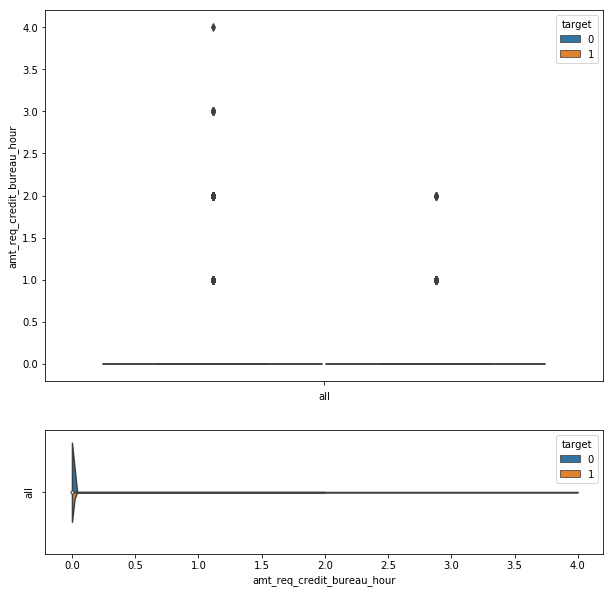

In [67]:
numerical_plot(df_appl, "target", "amt_req_credit_bureau_hour");

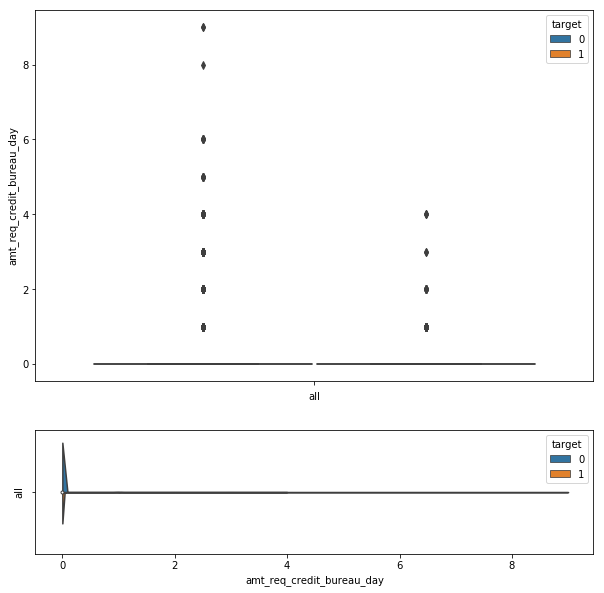

In [68]:
numerical_plot(df_appl, "target", "amt_req_credit_bureau_day");

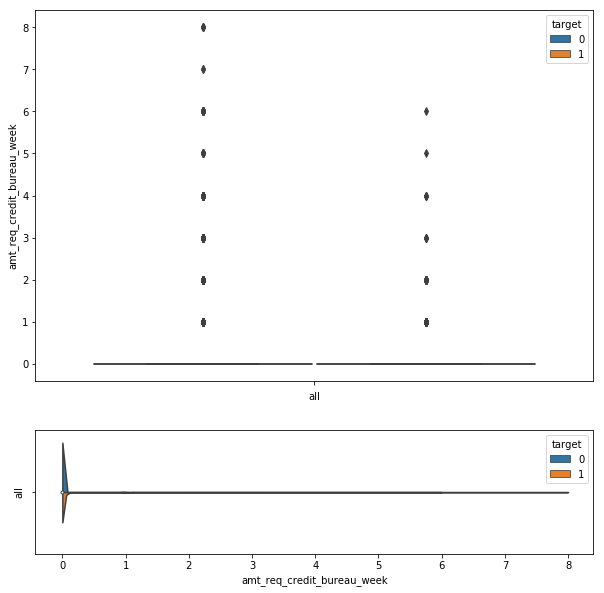

In [69]:
numerical_plot(df_appl, "target", "amt_req_credit_bureau_week");

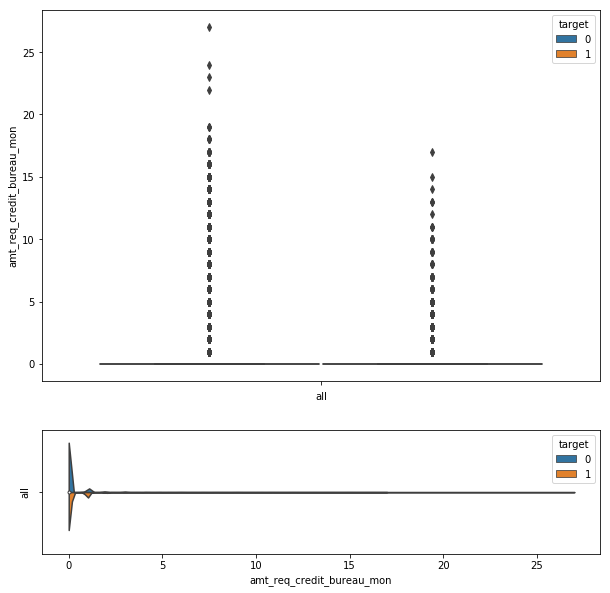

In [70]:
numerical_plot(df_appl, "target", "amt_req_credit_bureau_mon");

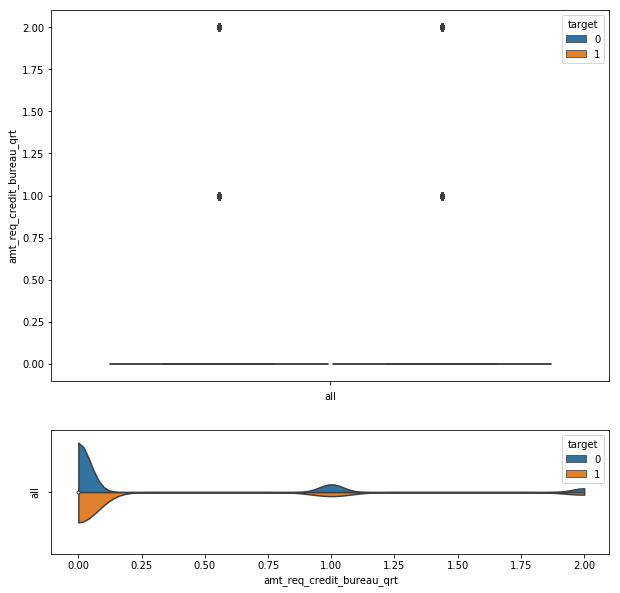

In [71]:
numerical_plot(df_appl, "target", "amt_req_credit_bureau_qrt", winsorize=(0, 0.99));

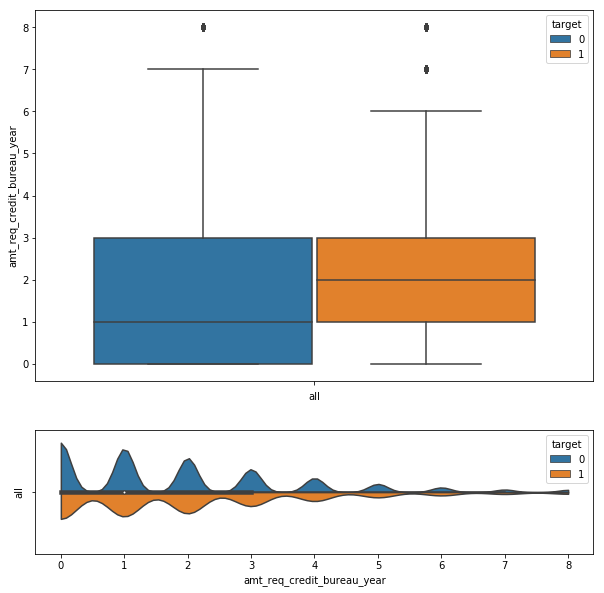

In [72]:
numerical_plot(df_appl, "target", "amt_req_credit_bureau_year", winsorize=(0, 0.99));